# Coupled-Dipole Method (Mie Polarizabilities)

This notebook contains code for computing the reflection and transmission of arrays of sphere. Polarizabilities are computed with the dipolar Mie coefficients. The array properties are computed with the coupled-dipole method.

Import matplotlib, numpy, and scipy libraries.

In [1]:
#import pymiecoated
#from pymiecoated import Mie
import matplotlib.pyplot as plt
import numpy
from pylab import *
from scipy.special import jv, yv
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import Axes3D

Define wrappers for the electric/magnetic dipolar Mie coefficients using the coated_mie_coeff() code stolen from the pymiecoated package. Note that here the inputs are the *permitivities*, not the the refractive indicies, and the normalized size parameters 2pi*r/lambda.

In [2]:
def coated_mie_coeff(eps1,eps2,x,y):
    
    """Mie coefficients for the dual-layered (coated) sphere.

       Args:
          eps: The complex relative permittivity of the core.
          eps2: The complex relative permittivity of the shell.
          x: The size parameter of the core.
          y: The size parameter of the shell.

       Returns:
          A tuple containing (an, bn, nmax) where an and bn are the Mie
          coefficients and nmax is the maximum number of coefficients.
    """
    
    m1 = sqrt(eps1) #refractive index 1
    m2 = sqrt(eps2) #refractive index 1
    m = m2/m1       #enviornment normalized refractive index
    u = m1*x        #refractive index normalized size parameter
    v = m2*x        #refractive index normalized size parameter
    w = m2*y        #refractive index normalized size parameter

    #nmax = int(round(2+y+4*y**(1.0/3.0)))
    nmax = 1 #only calculate the first term
    mx = max(abs(m1*y),abs(w))
    nmx = int(round(max(nmax,mx)+16))
    nmax1 = nmax-1
    n = arange(nmax)

    dnu = zeros(1,dtype=complex)
    dnv = zeros(1,dtype=complex)
    dnw = zeros(1,dtype=complex)
    dnx = zeros(nmx,dtype=complex)

    for (z, dn) in zip((u,v,w),(dnu,dnv,dnw)):
        for j in xrange(nmx-1,0,-1):
            r = (j+1.0)/z
            dnx[j-1] = r - 1.0/(dnx[j]+r)
        dn[:] = dnx[:nmax]

    nu = n+1.5
    vwy = [v,w,y]
    sx = [sqrt(0.5*pi*xx) for xx in vwy]
    (pv,pw,py) = [s*jv(nu,xx) for (s,xx) in zip(sx,vwy)]
    (chv,chw,chy) = [-s*yv(nu,xx) for (s,xx) in zip(sx,vwy)]
    p1y = hstack((sin(y), py[:nmax1]))
    ch1y = hstack((cos(y), chy[:nmax1]))
    gsy = py-complex(0,1)*chy
    gs1y = p1y-complex(0,1)*ch1y

    uu = m*dnu-dnv
    vv = dnu/m-dnv
    fv = pv/chv
    fw = pw/chw
    ku1 = uu*fv/pw
    kv1 = vv*fv/pw
    pt = pw-chw*fv
    prat = pw/pv/chv
    ku2 = uu*pt+prat
    kv2 = vv*pt+prat
    dns1 = ku1/ku2
    gns1 = kv1/kv2

    dns = dns1+dnw
    gns = gns1+dnw
    nrat = (n+1)/y
    
    a1 = dns/m2+nrat
    b1 = m2*gns+nrat
    
    #mie coefficients
    an = (py*a1-p1y)/(gsy*a1-gs1y)
    bn = (py*b1-p1y)/(gsy*b1-gs1y)

    return (an, bn)

def mie_coeff(eps,x):
    return coated_mie_coeff(eps,eps,x,x)

a1, b1, = mie_coeff(3.42,2)

def aTest(eps,x):
    a1, b1, = mie_coeff(eps,x)
    return a1
#aTest = numpy.vectorize(aTest,otypes=[numpy.complex])

#print a1
#print b1

Converting mie_coeff() with numpy.vectorize() is too tricky, so we'll just make a function that takes X,Y vectors as inputs and returns the result Z as output.

In [8]:
def matrixMieCoeff(mList,xList):
    a_out = empty([len(mList),len(xList)],dtype=float)
    b_out = empty([len(mList),len(xList)],dtype=float)
    
    total = len(mList)*len(xList)
    current = 0;
    
    for i in range(0,len(mList)):
        for k in range(0,len(xList)):
            a1, b1  = mie_coeff(mList[i]**2,2*pi*xList[k])
            a_out[i,k], b_out[i,k] = abs(a1), abs(b1)
            current += 1
            #print 'completed ', current, ' of ', total
    
    return a_out, b_out

In [5]:
refIndex = numpy.arange(2,4.025,0.025)
sizeParam = numpy.arange(0.01,1,0.01)

X,Y = np.meshgrid(sizeParam, refIndex)

Za, Zb = matrixMieCoeff(refIndex,sizeParam)

fig = plt.figure(figsize=(6,4), dpi=300);
ax = fig.add_axes([0,0,1,1]) # left, bottom, width, height (range 0 to 1)

#ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
#ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
#ax.set_xlim(8e-6,14e-6)
ax.set_ylim(2,4)
ax.set_xlabel('Size Parameter',size=12);
ax.set_ylabel('Refractive Index',size=12);
ax.set_title('Electric Mie Coefficient',size=16);

cax  = ax.pcolor(X,Y,Za)
cbar = fig.colorbar(cax)

fig2 = plt.figure(figsize=(6,4), dpi=300);
ax2  = fig2.add_axes([0,0,1,1]) # left, bottom, width, height (range 0 to 1)

#ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
#ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
#ax.set_xlim(8e-6,14e-6)
ax2.set_ylim(2,4)
ax2.set_xlabel('Size Parameter',size=12);
ax2.set_ylabel('Refractive Index',size=12);
ax2.set_title('Magnetic Mie Coefficient',size=16);

cax2 = ax2.pcolor(X,Y,Zb)
cbar2 = fig2.colorbar(cax2)

NameError: name 'numpy' is not defined

Define Green's functions, electric & magnetic Mie polarizabilities, effective electric & magnetic Mie polarizabilities, reflection and transmission coefficients.

...and a function to compute the reflection coefficent

In [3]:
def greens(l,a,b,points):
    s = 0 + 0.0j;
    k=2*pi/l;
    for n in range(-points,points):
        for m in range(-points,points):
            if n!=0 and m!=0:
                rx=a*n
                ry=b*m
                #print 'rx = ', rx, ', ry = ', ry
                r = sqrt((rx**2)+(ry**2))
                #print r
                theta = math.atan2(ry,rx)
                #print theta
                s = s + (((1-(1j*k*r))*((3*(cos(theta)**2))-1)*exp(1j*k*r))/(r**3)) 
                s = s + (((k**2)*(sin(theta)**2)*exp(1j*k*r))/r)
                #print s
    return s/(4*pi)

def omega(l): #takes wavelength as input and returns the angular frequency
    return 2*pi*3e8/l

def alphaE(eps,radius,wavelength): #electric polarizability of a Mie resonator
    a1, b1 = mie_coeff(eps,2*pi*radius/wavelength)
    return a1*1j*6*pi*((2*pi/wavelength)**(-3))

def alphaH(eps,radius,wavelength): #electric polarizability of a Mie resonator
    a1, b1 = mie_coeff(eps,2*pi*radius/wavelength)
    return b1*1j*6*pi*((2*pi/wavelength)**(-3))

def alphaEeff(eps,radius,wavelength,period,maxn): #effective polarizability of a Lorentzian resonator in an infinite periodic array
    x = radius/wavelength
    return 1/((1/alphaE(eps,radius,wavelength))-greens(wavelength,period,period,maxn))

def alphaHeff(eps,radius,wavelength,period,maxn): #effective polarizability of a Lorentzian resonator in an infinite periodic array
    x = radius/wavelength
    return 1/((1/alphaH(eps,radius,wavelength))-greens(wavelength,period,period,maxn))

def r0(eps,radius,wavelength,period,maxn):
    return 1j*(2*pi/wavelength)*0.5*(period**-2)*( alphaEeff(eps,radius,wavelength,period,maxn) - alphaHeff(eps,radius,wavelength,period,maxn) )

def reflection(eps,radius,wavelength,period,maxn): #reflection coefficient of a Lorentzian resonator in an infinite periodic array
    return r0(eps,radius,wavelength,period,maxn)**2

def transmission(eps,radius,wavelength,period,maxn): #transmission coefficient of a Lorentzian resonator in an infinite periodic array
    return reflection(eps,radius,wavelength,period,maxn) + (( 1+r0(eps,radius,wavelength,period,maxn) )**2) - r0(eps,radius,wavelength,period,maxn)

def sigma(eps,radius,wavelength,period,maxn):
    z = (2*pi/wavelength)*( alphaEeff(eps,radius,wavelength,period,maxn) + alphaHeff(eps,radius,wavelength,period,maxn) )
    return z.imag;

def REFr(rList,waveList,period,points):
    r_out = empty([len(rList),len(waveList)],dtype=float)
    
    total = len(rList)*len(waveList)
    current = 0;
    
    for i in range(0,len(rList)):
        for k in range(0,len(waveList)):
            r_out[i,k] = abs(reflection(11.7,rList[i],waveList[k],period,points))
            current += 1
            print 'completed ', current, ' of ', total
    
    return r_out

def REFp(pList,waveList,points):
    r_out = empty([len(pList),len(waveList)],dtype=float)
    
    total = len(pList)*len(waveList)
    current = 0;
    
    for i in range(0,len(pList)):
        for k in range(0,len(waveList)):
            r_out[i,k] = abs(reflection(11.7,2e-6,waveList[k],pList[i],points))
            current += 1
            print 'completed ', current, ' of ', total
    
    return r_out

Compute Green's function for a fixed periodicity over a range of wavelengths

In [4]:
wavelengths = arange(9e-6,14e-6,0.01e-6)
greensvalues = empty([len(wavelengths)],dtype=complex)

for i in range(0,len(wavelengths)):
    greensvalues[i] = greens(wavelengths[i],10e-6,10e-6,400)
    print 'completed ', i, ' of ', len(wavelengths)

completed  0  of  500
completed  1  of  500
completed  2  of  500
completed  3  of  500
completed  4  of  500
completed  5  of  500
completed  6  of  500
completed  7  of  500
completed  8  of  500
completed  9  of  500
completed  10  of  500
completed  11  of  500
completed  12  of  500
completed  13  of  500
completed  14  of  500
completed  15  of  500
completed  16  of  500
completed  17  of  500
completed  18  of  500
completed  19  of  500
completed  20  of  500
completed  21  of  500
completed  22  of  500
completed  23  of  500
completed  24  of  500
completed  25  of  500
completed  26  of  500
completed  27  of  500
completed  28  of  500
completed  29  of  500
completed  30  of  500
completed  31  of  500
completed  32  of  500
completed  33  of  500
completed  34  of  500
completed  35  of  500
completed  36  of  500
completed  37  of  500
completed  38  of  500
completed  39  of  500
completed  40  of  500
completed  41  of  500
completed  42  of  500
completed  43  of  50

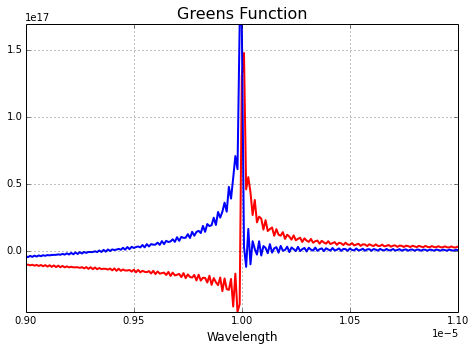

In [6]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1]) # left, bottom, width, height (range 0 to 1)
axes.plot(wavelengths, greensvalues.real, 'r',wavelengths, greensvalues.imag, 'b',linewidth=2);
axes.set_xlabel('Wavelength',size=12);
axes.set_title('Greens Function',size=16);
axes.axis('tight');
axes.grid(True);
axes.ticklabel_format(style='sci',axis='x',scilimits=(0,0));
axes.ticklabel_format(style='sci',axis='y',scilimits=(0,0));
axes.set_xlim(9e-6,11e-6);
#axes.set_ylim(0,5e16);

Compute Green's function to test against "Collective Resonances in Gold Nanoparticle Arrays"

In [ ]:
wavelengthsPRL = arange(500e-9,900e-9,1e-9)
greensvaluesPRL = empty([len(wavelengthsPRL)],dtype=complex)

for i in range(0,len(wavelengthsPRL)):
    greensvaluesPRL[i] = (1e-18)*greens(wavelengthsPRL[i],779e-9,779e-9,150)
    print 'completed ', i, ' of ', len(wavelengthsPRL)

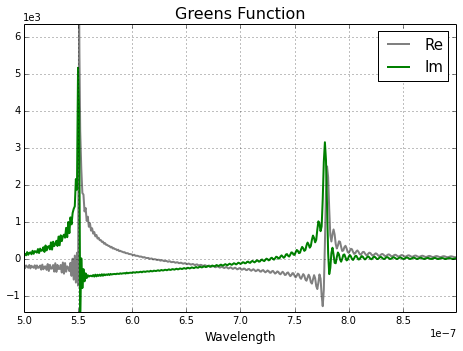

In [17]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1]) # left, bottom, width, height (range 0 to 1)
axes.plot(wavelengthsPRL, greensvaluesPRL.real, 'gray',wavelengthsPRL, greensvaluesPRL.imag, 'green',linewidth=2);
axes.set_xlabel('Wavelength',size=12);
axes.set_title('Greens Function',size=16);
axes.axis('tight');
axes.grid(True);
axes.ticklabel_format(style='sci',axis='x',scilimits=(0,0));
axes.ticklabel_format(style='sci',axis='y',scilimits=(0,0));
axes.legend(["Re","Im"],prop={'size':15});
#axes.set_yscale("log")
#axes.set_xlim(9e-6,14e-6);
#axes.set_ylim(0,5e16);

Smooth the Green's function using an FFT filter. (

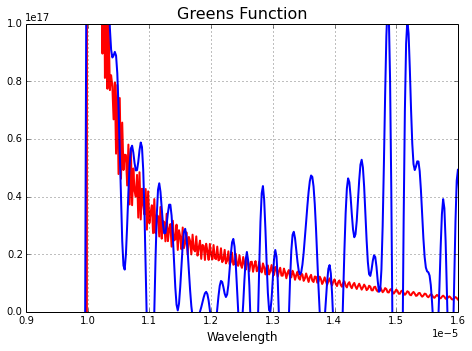

In [99]:
import scipy.fftpack

N = len(wavelengths2)
x = wavelengths2
y = greensvalues2.real

# do a 1d DFT
w = scipy.fftpack.rfft(y)

f = scipy.fftpack.rfftfreq(N, x[1]-x[0])

spectrum = w**2

cutoff_idx = spectrum < (spectrum.max()/10)
w2 = w.copy()
w2[cutoff_idx] = 0

y2 = scipy.fftpack.irfft(w2)

fig = plt.figure()
axes = fig.add_axes([0,0,1,1]) # left, bottom, width, height (range 0 to 1)
axes.plot(x, y, 'r',x, y2, 'b',linewidth=2);
axes.set_xlabel('Wavelength',size=12);
axes.set_title('Greens Function',size=16);
axes.axis('tight');
axes.grid(True);
axes.ticklabel_format(style='sci',axis='x',scilimits=(0,0));
axes.ticklabel_format(style='sci',axis='y',scilimits=(0,0));
axes.set_xlim(9e-6,16e-6);
axes.set_ylim(0,1e17);

Smooth with a Savitzky-Golay filter

In [17]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError, msg:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

greensvalues_real_s = savitzky_golay(greensvalues.real, 7, 3) # window size 51, polynomial order 3
greensvalues_imag_s = savitzky_golay(greensvalues.imag, 7, 3) # window size 51, polynomial order 3
greensvalues_s = greensvalues_real_s + 1j*greensvalues_imag_s

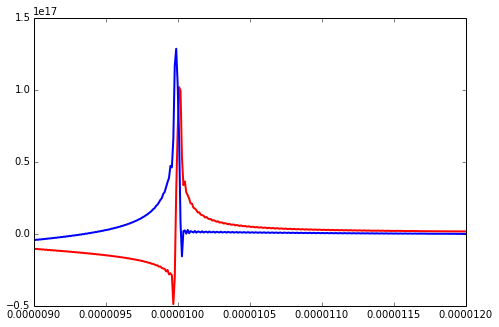

In [26]:
fig = plt.figure()
axes = fig.add_axes([0,0,1,1]) # left, bottom, width, height (range 0 to 1)
axes.plot(wavelengths, greensvalues_s.real, 'r', wavelengths, greensvalues_s.imag, 'b',linewidth=2);
axes.set_xlim(9e-6,12e-6);
#axes.set_ylim(0,1e17);

Using the previously calculated Green's function values, compute the reflection and transmission coefficients for a range of radii.

In [21]:
radii = arange(1e-6,2.6e-6,0.01e-6)
X,Y = np.meshgrid(wavelengths, radii)

def alphaEeffFast(eps,radius,wavelength,i): #effective polarizability of a Lorentzian resonator in an infinite periodic array
    x = radius/wavelength
    return 1/((1/alphaE(eps,radius,wavelength))-greensvalues_s[i])

def alphaHeffFast(eps,radius,wavelength,i): #effective polarizability of a Lorentzian resonator in an infinite periodic array
    x = radius/wavelength
    return 1/((1/alphaH(eps,radius,wavelength))-greensvalues_s[i])

def r0Fast(eps,radius,wavelength,period,i):
    return 1j*(2*pi/wavelength)*0.5*(period**-2)*( alphaEeffFast(eps,radius,wavelength,i) - alphaHeffFast(eps,radius,wavelength,i) )

def reflectionFast(eps,radius,wavelength,period,i): #reflection coefficient of a Lorentzian resonator in an infinite periodic array
    return r0Fast(eps,radius,wavelength,period,i)**2

def refFast(radiiList,waveList):
    r_out = empty([len(radiiList),len(waveList)],dtype=float)
    
    total = len(radiiList)*len(waveList)
    current = 0;
    
    for i in range(0,len(radiiList)):
        for k in range(0,len(waveList)):
            r_out[i,k] = abs(reflectionFast(11.7,radiiList[i],waveList[k],10e-6,k))
            current += 1
        print 'completed ', current, ' of ', total
    
    return r_out

Z = refFast(radii,wavelengths)

completed  500  of  80000
completed  1000  of  80000
completed  1500  of  80000
completed  2000  of  80000
completed  2500  of  80000
completed  3000  of  80000
completed  3500  of  80000
completed  4000  of  80000
completed  4500  of  80000
completed  5000  of  80000
completed  5500  of  80000
completed  6000  of  80000
completed  6500  of  80000
completed  7000  of  80000
completed  7500  of  80000
completed  8000  of  80000
completed  8500  of  80000
completed  9000  of  80000
completed  9500  of  80000
completed  10000  of  80000
completed  10500  of  80000
completed  11000  of  80000
completed  11500  of  80000
completed  12000  of  80000
completed  12500  of  80000
completed  13000  of  80000
completed  13500  of  80000
completed  14000  of  80000
completed  14500  of  80000
completed  15000  of  80000
completed  15500  of  80000
completed  16000  of  80000
completed  16500  of  80000
completed  17000  of  80000
completed  17500  of  80000
completed  18000  of  80000
completed  1

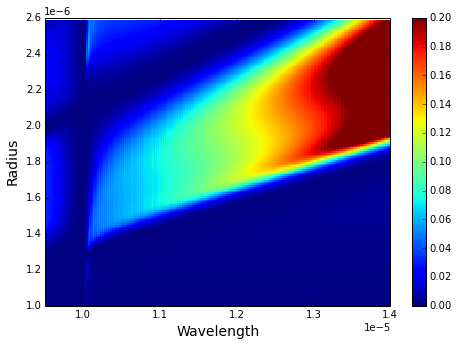

In [25]:
fig = plt.figure(figsize=(6,4), dpi=300);
ax = fig.add_axes([0,0,1,1]) # left, bottom, width, height (range 0 to 1)

ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
ax.set_xlim(9.5e-6,14e-6)
ax.set_ylim(1e-6,2.6e-6)
ax.set_xlabel('Wavelength',size=14);
ax.set_ylabel('Radius',size=14);
#ax.set_title('Electric Mie Coefficient',size=16);

cax = ax.pcolor(X, Y, Z,vmin=0.0, vmax=0.2)
cbar = fig.colorbar(cax)

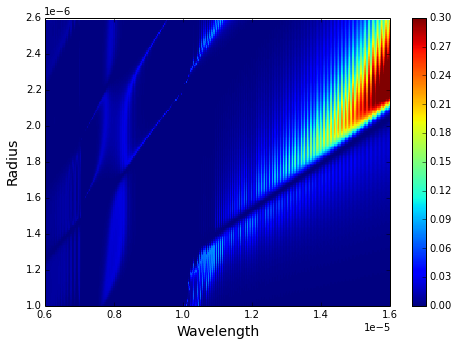

In [53]:
fig = plt.figure(figsize=(6,4), dpi=300);
ax = fig.add_axes([0,0,1,1]) # left, bottom, width, height (range 0 to 1)

ax.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
#ax.set_xlim(9e-6,16e-6)
#ax.set_ylim(1e-6,2.2e-6)
ax.set_xlabel('Wavelength',size=14);
ax.set_ylabel('Radius',size=14);
#ax.set_title('Electric Mie Coefficient',size=16);

cax = ax.pcolor(X, Y, Z,vmin=0.0, vmax=0.3)
cbar = fig.colorbar(cax)